In [0]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [14]:
# Get the stock quote
df = web.DataReader('AAPL', data_source='yahoo', start='2014-01-01', end='2019-06-02')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-01-02,79.575714,78.860001,79.382858,79.018570,58671200.0,70.747330
2014-01-03,79.099998,77.204285,78.980003,77.282860,98116900.0,69.193306
2014-01-06,78.114288,76.228569,76.778572,77.704285,103152700.0,69.570625
2014-01-07,77.994286,76.845711,77.760002,77.148575,79302300.0,69.073074
2014-01-08,77.937141,76.955711,76.972855,77.637146,64632400.0,69.510536
...,...,...,...,...,...,...
2019-05-24,182.139999,178.619995,180.199997,178.970001,23714700.0,176.859283
2019-05-28,180.589996,177.910004,178.919998,178.229996,27948200.0,176.128006
2019-05-29,179.350006,176.000000,176.419998,177.380005,28481200.0,175.288025


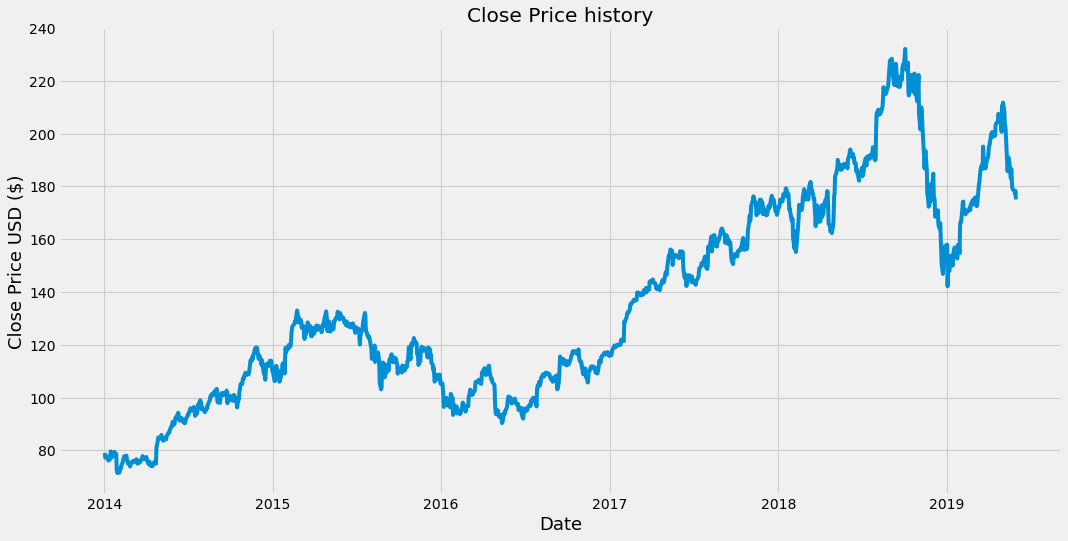

In [15]:
plt.figure(figsize=(16, 8))
plt.title('Close Price history')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [0]:
data = df.filter(['Close'])
dataset = data.values # dataframe => numpy array
training_data_len = math.ceil(len(dataset) * .8)

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.04743445],
       [0.03663169],
       [0.03925457],
       ...,
       [0.65961893],
       [0.66534484],
       [0.64524191]])

In [18]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i - 60:i, 0])
  y_train.append(train_data[i, 0])
  if i <= 61:
    print(x_train)
    print(y_train)
    print()

[array([0.04743445, 0.03663169, 0.03925457, 0.03579593, 0.03883671,
       0.03266621, 0.02948316, 0.03196382, 0.04144183, 0.05119542,
       0.04843029, 0.03635605, 0.04382462, 0.04599407, 0.05014627,
       0.0411573 , 0.0450961 , 0.00597487, 0.00086245, 0.        ,
       0.00072907, 0.00155596, 0.00801098, 0.01138961, 0.01131848,
       0.01769345, 0.02597115, 0.03216829, 0.03213273, 0.03969911,
       0.03930794, 0.04108617, 0.03342196, 0.02789164, 0.02264584,
       0.02469084, 0.01980958, 0.01562182, 0.02479754, 0.02352606,
       0.02487755, 0.02797165, 0.02896749, 0.02753599, 0.02726039,
       0.02768713, 0.03228387, 0.03274622, 0.0274471 , 0.02214793,
       0.02397065, 0.02811391, 0.02798946, 0.02571331, 0.02942091,
       0.03504017, 0.04019703, 0.03556473, 0.03350197, 0.03296849])]
[0.032861794799302624]

[array([0.04743445, 0.03663169, 0.03925457, 0.03579593, 0.03883671,
       0.03266621, 0.02948316, 0.03196382, 0.04144183, 0.05119542,
       0.04843029, 0.03635605, 0.0

In [0]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [25]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1030, 60, 1)

In [0]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [0]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [37]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
1030/1030 [==============================] - 39s 38ms/step - loss: 6.4506e-04


In [0]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [0]:
x_test = np.array(x_test)

In [0]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [0]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [42]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.45069554272819967

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


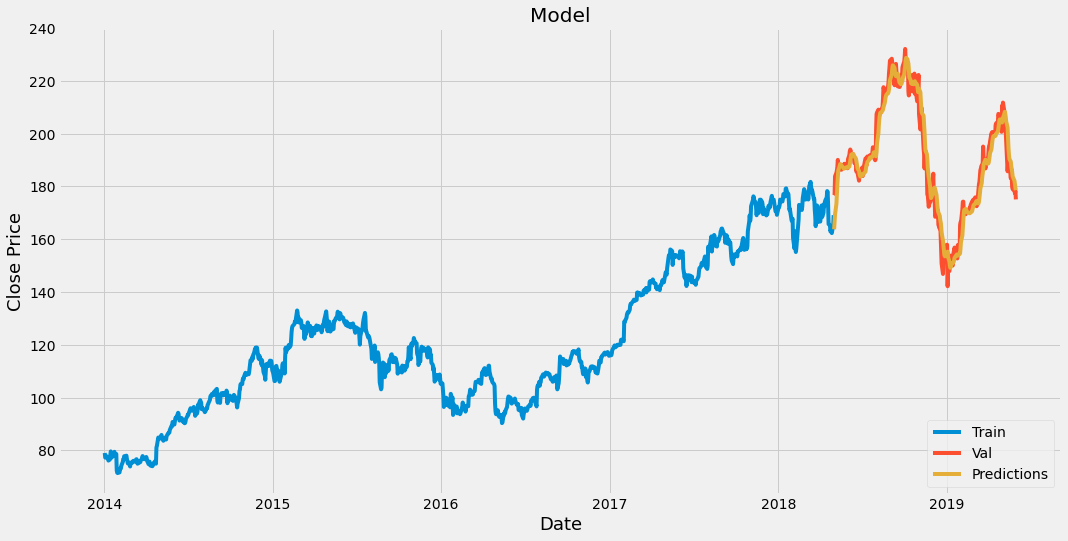

In [43]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [45]:
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2014-01-01', end='2019-06-02')
new_df = apple_quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[177.55714]]


In [48]:
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2019-06-03', end='2019-06-03')
print(apple_quote2['Close'])

Date
2019-06-03    173.300003
Name: Close, dtype: float64
